In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 
import os 
from spot import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import bisect

In [3]:
sns.set_theme(style='ticks', font='Times New Roman', font_scale=1.3)

In [9]:
methods = ['TopoGuard+', 'LinkGuard', 'CTAD', 'TrustTopo',  'RLV-RF',
           'RLV-MLP', 'CLV-RAW', 'CLV-OPT']
log_dirs = ['topoguard_log', 'linkguard_log', 'ctad_log', 'trusttopo_log', 
            'rf_log', 'mlp_log', 'clv_log_raw', 'clv_log_opt']

scales = [i for i in range(10, 110, 10)]

colors = ['blue', 'cyan', 'orange', 'green', 'red', 'maroon', 'darkviolet', 'purple']

stats = {
    log_dir: {
        'TPR': [],
        'FPR': [],
        'Pr': [],
        'F1': [],
        'AUC': [],
    } for log_dir in log_dirs
}
# TPR:0.9955,FPR:0.0,Pr:1.0,F1:0.9977449260836884,AUC:0.99775
for scale in scales:
    for dir in log_dirs:
        fpath = os.path.join(dir, '{}_{}.txt'.format(dir, scale))
        tpr_list = []
        fpr_list = []
        pr_list = []
        f1_list = []
        auc_list = []
        with open(fpath, 'r') as fp:
            while True:
                line = fp.readline()
                if not line:
                    break 
                tpr_item, fpr_item, pr_item, f1_item, auc_item = line.split(',')
                tpr = 100 * float(tpr_item.split(':')[1])
                fpr = 100 * float(fpr_item.split(':')[1])
                pr = 100 * float(pr_item.split(':')[1])
                f1 = 100 * float(f1_item.split(':')[1])
                auc = 100 * float(auc_item.split(':')[1])
                tpr_list.append(tpr)
                fpr_list.append(fpr)
                pr_list.append(pr)
                f1_list.append(f1)
                auc_list.append(auc)
        med_tpr = np.mean(tpr_list)
        med_fpr = np.mean(fpr_list)
        med_pr = np.mean(pr_list)
        med_f1 = np.mean(f1_list)
        med_auc = np.mean(auc_list)
        (stats[dir]['TPR']).append(np.round(med_tpr,4))
        (stats[dir]['FPR']).append(np.round(med_fpr, 4))
        (stats[dir]['Pr']).append(np.round(med_pr, 4))
        (stats[dir]['F1']).append(np.round(med_f1, 4))
        (stats[dir]['AUC']).append(np.round(med_auc, 4))

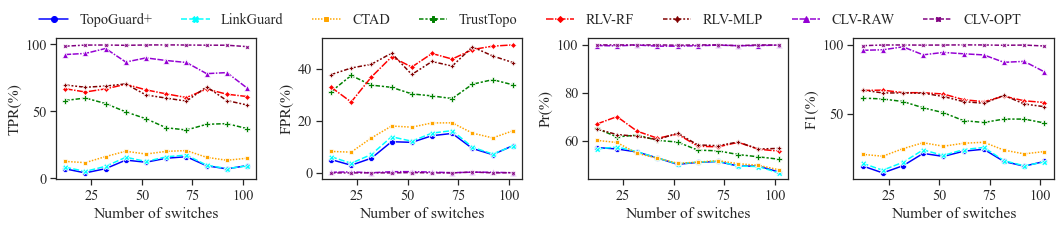

In [10]:
indicators = ['TPR', 'FPR', 'Pr', 'F1']
f, axes = plt.subplots(1, len(indicators), figsize=(15, 3))
index = [scale+2 for scale in scales]
for i, ind in enumerate(indicators):
    data = np.array([stats[dir][ind] for dir in log_dirs])
    df = pd.DataFrame(data.T, index=index, columns=methods)
    ax = sns.lineplot(data=df, markers=True, ax=axes[i], palette=colors)
    ax.set_xlabel('Number of switches')
    ax.set_ylabel('{}(%)'.format(ind))
    ax.legend_.remove()
    
lines, labels = f.axes[-1].get_legend_handles_labels()
f.legend(lines, labels, frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(methods))
f.tight_layout()
f.savefig('performance.png', format='png', bbox_inches='tight', dpi=300)
    

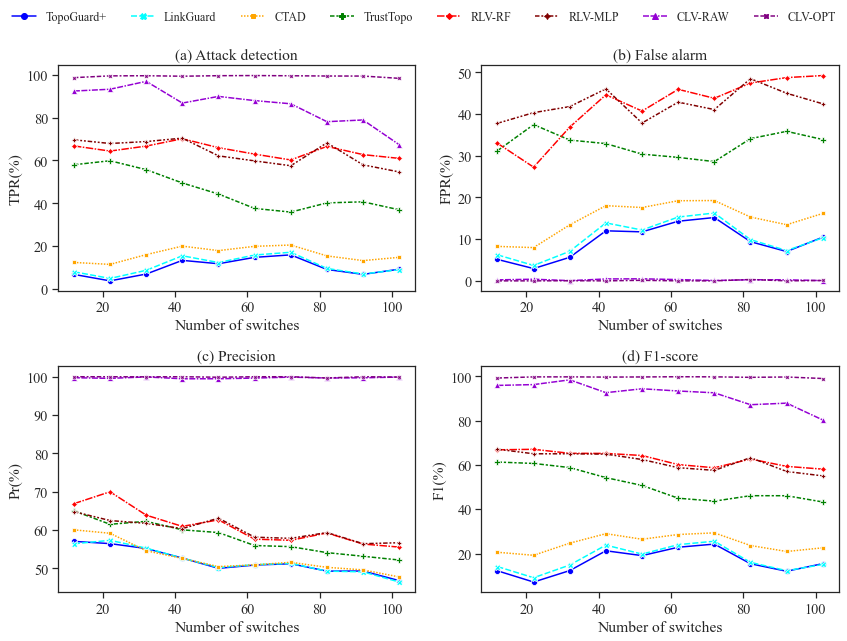

In [15]:
indicators = ['TPR', 'FPR', 'Pr', 'F1']
titles = ['(a) Attack detection', 
          '(b) False alarm',
          '(c) Precision',
          '(d) F1-score']
f, axes = plt.subplots(2, len(indicators)//2, figsize=(12, 8.6))
index = [scale+2 for scale in scales]
for i, ind in enumerate(indicators):
    data = np.array([stats[dir][ind] for dir in log_dirs])
    df = pd.DataFrame(data.T, index=index, columns=methods)
    ax = sns.lineplot(data=df, markers=True, ax=axes[i//2][i%2], palette=colors)
    ax.set_xlabel('Number of switches')
    ax.set_ylabel('{}(%)'.format(ind))
    ax.legend_.remove()
    ax.set_title(titles[i])
    
lines, labels = f.axes[-1].get_legend_handles_labels()
f.legend(lines, labels, frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(methods), fontsize=12)
f.tight_layout()
f.savefig('performance_2.png', format='png', bbox_inches='tight', dpi=300)
    

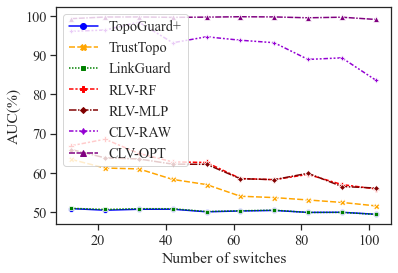

In [51]:
# AUC

indicator = 'AUC'
data = np.array([
    stats[dir][indicator] for dir in log_dirs])

data = pd.DataFrame(data.T, index=index, columns=methods)
ax = sns.lineplot(data=data, markers=True, palette=colors)
ax.set_xlabel('Number of switches')
ax.set_ylabel('AUC(%)')
ax.legend(loc='upper left')

In [52]:
gammas = [0.8, 0.85, 0.9, 0.95]

scales = [i for i in range(10, 110, 10)]

colors = ['orange', 'green', 'red', 'blue',]

stats = {
    'gamma_{}'.format(gamma): {
        'TPR': [],
        'FPR': [],
        'Pr': [],
        'F1': [],
        'AUC': [],
    } for gamma in gammas
}
# TPR:0.9955,FPR:0.0,Pr:1.0,F1:0.9977449260836884,AUC:0.99775
for scale in scales:
    for gamma in gammas:
        tpr_list = []
        fpr_list = []
        pr_list = []
        f1_list = []
        auc_list = []
        with open('clv_log_2/gamma_{}/clv_log_{}.txt'.format(gamma, scale), 'r') as fp:
            while True:
                line = fp.readline()
                if not line:
                    break 
                tpr_item, fpr_item, pr_item, f1_item, auc_item = line.split(',')
                tpr = 100 * float(tpr_item.split(':')[1])
                fpr = 100 * float(fpr_item.split(':')[1])
                pr = 100 * float(pr_item.split(':')[1])
                f1 = 100 * float(f1_item.split(':')[1])
                auc = 100 * float(auc_item.split(':')[1])
                tpr_list.append(tpr)
                fpr_list.append(fpr)
                pr_list.append(pr)
                f1_list.append(f1)
                auc_list.append(auc)
        med_tpr = np.mean(tpr_list)
        med_fpr = np.mean(fpr_list)
        med_pr = np.mean(pr_list)
        med_f1 = np.mean(f1_list)
        med_auc = np.mean(auc_list)
        key = 'gamma_{}'.format(gamma)
        (stats[key]['TPR']).append(np.round(med_tpr,4))
        (stats[key]['FPR']).append(np.round(med_fpr, 4))
        (stats[key]['Pr']).append(np.round(med_pr, 4))
        (stats[key]['F1']).append(np.round(med_f1, 4))
        (stats[key]['AUC']).append(np.round(med_auc, 4))

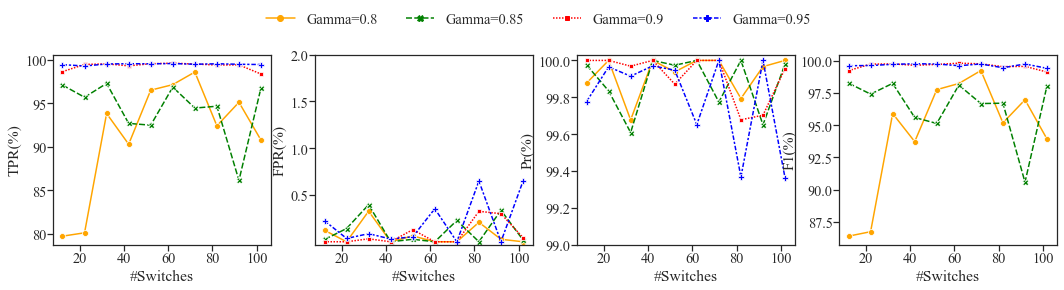

In [53]:
indicators = ['TPR', 'FPR', 'Pr', 'F1']
f, axes = plt.subplots(1, len(indicators), figsize=(18, 3.5))

columns = ['Gamma={}'.format(g) for g in gammas]

for i, ind in enumerate(indicators):
    data = np.array([
            stats['gamma_0.8'][ind],
            stats['gamma_0.85'][ind],
            stats['gamma_0.9'][ind],
            stats['gamma_0.95'][ind]])
    df = pd.DataFrame(data.T, index=index, columns=columns)
    ax = sns.lineplot(data=df, markers=True, ax=axes[i], palette=colors)
    if ind == 'FPR':
        ax.set_yticks([0.5, 1, 1.5, 2])
    elif ind == 'Pr':
        ax.set_yticks([99, 99.2, 99.4, 99.6, 99.8, 100])
    ax.tick_params(pad=0)
    ax.set_xlabel('#Switches')
    ax.set_ylabel('{}(%)'.format(ind))
    ax.legend_.remove()

lines, labels = f.axes[-1].get_legend_handles_labels()
f.legend(lines, labels, frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(gammas))
    
    

In [54]:
DelayLimit = [4, 5, 6, 7]

scales = [i for i in range(10, 110, 10)]

colors = ['orange', 'green', 'red', 'blue',]

stats = {
    'limit_{}'.format(limit): {
        'TPR': [],
        'FPR': [],
        'Pr': [],
        'F1': [],
        'AUC': [],
    } for limit in DelayLimit
}
# TPR:0.9955,FPR:0.0,Pr:1.0,F1:0.9977449260836884,AUC:0.99775
for scale in scales:
    for limit in DelayLimit:
        tpr_list = []
        fpr_list = []
        pr_list = []
        f1_list = []
        auc_list = []
        with open('clv_log_3/limit_{}/clv_log_{}.txt'.format(limit, scale), 'r') as fp:
            while True:
                line = fp.readline()
                if not line:
                    break 
                tpr_item, fpr_item, pr_item, f1_item, auc_item = line.split(',')
                tpr = 100 * float(tpr_item.split(':')[1])
                fpr = 100 * float(fpr_item.split(':')[1])
                pr = 100 * float(pr_item.split(':')[1])
                f1 = 100 * float(f1_item.split(':')[1])
                auc = 100 * float(auc_item.split(':')[1])
                tpr_list.append(tpr)
                fpr_list.append(fpr)
                pr_list.append(pr)
                f1_list.append(f1)
                auc_list.append(auc)
        med_tpr = np.mean(tpr_list)
        med_fpr = np.mean(fpr_list)
        med_pr = np.mean(pr_list)
        med_f1 = np.mean(f1_list)
        med_auc = np.mean(auc_list)
        key = 'limit_{}'.format(limit)
        (stats[key]['TPR']).append(np.round(med_tpr,4))
        (stats[key]['FPR']).append(np.round(med_fpr, 4))
        (stats[key]['Pr']).append(np.round(med_pr, 4))
        (stats[key]['F1']).append(np.round(med_f1, 4))
        (stats[key]['AUC']).append(np.round(med_auc, 4))

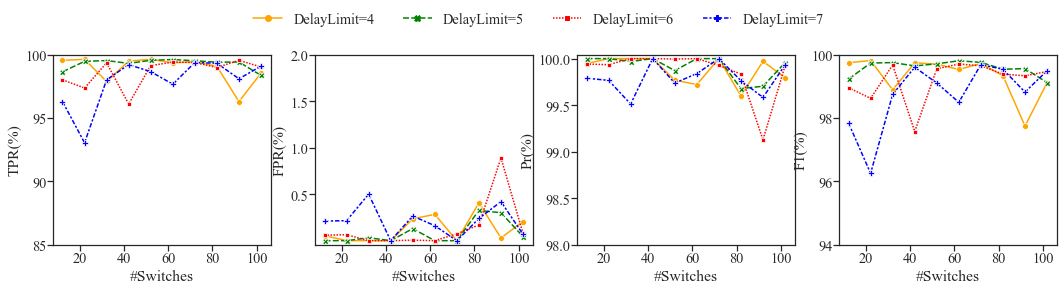

In [55]:
indicators = ['TPR', 'FPR', 'Pr', 'F1']
f, axes = plt.subplots(1, len(indicators), figsize=(18, 3.5))

columns = ['DelayLimit={}'.format(d) for d in DelayLimit]

for i, ind in enumerate(indicators):
    data = np.array([
            stats['limit_4'][ind],
            stats['limit_5'][ind],
            stats['limit_6'][ind],
            stats['limit_7'][ind]])
    df = pd.DataFrame(data.T, index=index, columns=columns)
    ax = sns.lineplot(data=df, markers=True, ax=axes[i], palette=colors)
    if ind == 'TPR':
        ax.set_yticks([85, 90, 95, 100])
    elif ind == 'FPR':
        ax.set_yticks([0.5, 1, 1.5, 2])
    elif ind == 'Pr':
        ax.set_yticks([98, 98.5, 99, 99.5, 100])
    elif ind == 'F1':
        ax.set_yticks([94, 96, 98, 100])
    ax.tick_params(pad=0)
    ax.set_xlabel('#Switches')
    ax.set_ylabel('{}(%)'.format(ind))
    ax.legend_.remove()

lines, labels = f.axes[-1].get_legend_handles_labels()
f.legend(lines, labels, frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(gammas))
    
    

In [56]:
scales = [i for i in range(10, 110, 10)]

intervals = [5, 10, 15, 20]

colors = ['orange', 'green', 'red', 'blue',]

columns = ['Interval={}'.format(d) for d in intervals]

stats = {
    'interval_{}'.format(ival): {
        'TPR': [],
        'FPR': [],
        'Pr': [],
        'F1': [],
        'AUC': [],
    } for ival in intervals
}
# TPR:0.9955,FPR:0.0,Pr:1.0,F1:0.9977449260836884,AUC:0.99775
for scale in scales:
    for interval in intervals:
        tpr_list = []
        fpr_list = []
        pr_list = []
        f1_list = []
        auc_list = []
        with open('clv_log_4/interval_{}/clv_log_{}.txt'.format(interval, scale), 'r') as fp:
            while True:
                line = fp.readline()
                if not line:
                    break 
                tpr_item, fpr_item, pr_item, f1_item, auc_item = line.split(',')
                tpr = 100 * float(tpr_item.split(':')[1])
                fpr = 100 * float(fpr_item.split(':')[1])
                pr = 100 * float(pr_item.split(':')[1])
                f1 = 100 * float(f1_item.split(':')[1])
                auc = 100 * float(auc_item.split(':')[1])
                tpr_list.append(tpr)
                fpr_list.append(fpr)
                pr_list.append(pr)
                f1_list.append(f1)
                auc_list.append(auc)
        med_tpr = np.mean(tpr_list)
        med_fpr = np.mean(fpr_list)
        med_pr = np.mean(pr_list)
        med_f1 = np.mean(f1_list)
        med_auc = np.mean(auc_list)
        key = 'interval_{}'.format(interval)
        (stats[key]['TPR']).append(np.round(med_tpr,4))
        (stats[key]['FPR']).append(np.round(med_fpr, 4))
        (stats[key]['Pr']).append(np.round(med_pr, 4))
        (stats[key]['F1']).append(np.round(med_f1, 4))
        (stats[key]['AUC']).append(np.round(med_auc, 4))

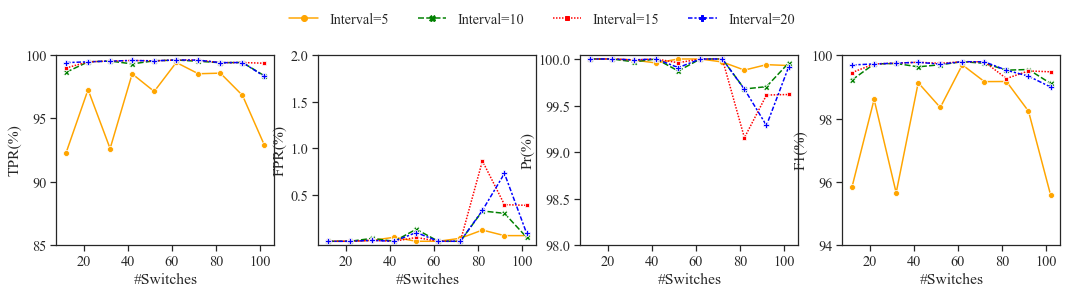

In [57]:
indicators = ['TPR', 'FPR', 'Pr', 'F1']
f, axes = plt.subplots(1, len(indicators), figsize=(18, 3.5))

columns = ['Interval={}'.format(d) for d in intervals]

for i, ind in enumerate(indicators):
    data = np.array([
        stats['interval_5'][ind],
        stats['interval_10'][ind],
        stats['interval_15'][ind],
        stats['interval_20'][ind]])
    
    df = pd.DataFrame(data.T, index=index, columns=columns)
    ax = sns.lineplot(data=df, markers=True, ax=axes[i], palette=colors)
    if ind == 'TPR':
        ax.set_yticks([85, 90, 95, 100])
    elif ind == 'FPR':
        ax.set_yticks([0.5, 1, 1.5, 2])
    elif ind == 'Pr':
        ax.set_yticks([98, 98.5, 99, 99.5, 100])
    elif ind == 'F1':
        ax.set_yticks([94, 96, 98, 100])
        
    ax.set_xlabel('#Switches')
    ax.set_ylabel('{}(%)'.format(ind))
    ax.legend_.remove()
lines, labels = f.axes[-1].get_legend_handles_labels()
f.legend(lines, labels, frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(gammas))
f.savefig('parameters.png', format='png', bbox_inches='tight', dpi=300, transparent=True)
    

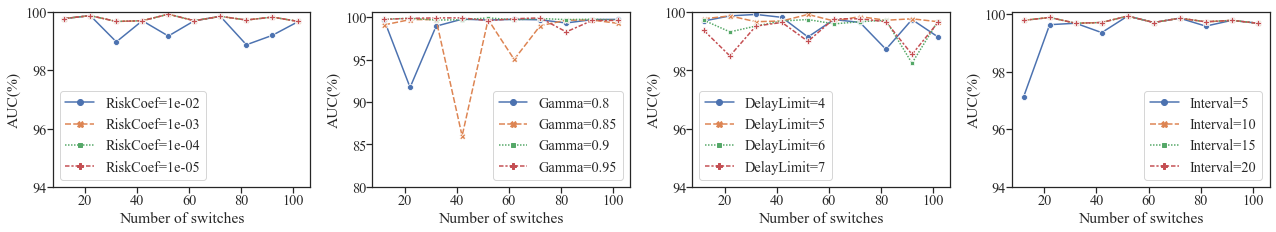

In [58]:
qs = [1e-2, 1e-3, 1e-4, 1e-5]
gammas = [0.8, 0.85, 0.9, 0.95]
delay_limits = [4, 5, 6, 7]
interval = [5, 10, 15, 20]

param_names = ['q', 'gamma','limit', 'interval']
param_objs = [qs, gammas, delay_limits, interval]
scales = [i for i in range(10, 110, 10)]
colors = ['blue', 'orange', 'green', 'red', 'maroon', 'darkviolet', 'purple']
labels = ['RiskCoef', 'Gamma', 'DelayLimit', 'Interval']

methods = ['TopoGuard+', 'TrustTopo', 'LinkGuard', 'RLV-RF',
           'RLV-MLP', 'CLV-RAW', 'CLV-OPT']
log_dirs = ['topoguard_log', 'trusttopo_log', 'linkguard_log',
            'rf_log', 'mlp_log', 'clv_log_raw', 'clv_log_opt']

f, axes = plt.subplots(1, len(param_objs), figsize=(18, 3.5))

for i, name in enumerate(param_names):
    data = []
    for value in param_objs[i]:
        if name == 'q':
            key = '{}_{:.0e}'.format(name, value)
        else:
            key = '{}_{}'.format(name, value)
        data_by_key = []
        for scale in scales:
            log_file = 'clv_log_{}/{}/clv_log_{}.txt'.format(
                i+1, key, scale)
            auc_list = []
            with open(log_file, 'r') as fp:
                line = fp.readline()
                if not line:
                    break 
                auc_item = line.split(',')[-1]
                auc_value = auc_item.split(':')[-1]
                auc_list.append(float(auc_value)*100)
            data_by_key.append(np.round(np.mean(auc_list), 4))
        data.append(data_by_key)
    data = np.array(data)
    if name == 'q':
        columns = ['{}={:.0e}'.format(labels[i], v) for v in param_objs[i]]
    else:
        columns = ['{}={}'.format(labels[i], v) for v in param_objs[i]]
    df = pd.DataFrame(data.T, index=index, columns=columns)
    ax = sns.lineplot(data=df,ax=axes[i], markers=True)
    ax.set_xlabel('Number of switches')
    ax.set_ylabel('AUC(%)')
    if i == 0:
        ax.set_yticks([94, 96, 98, 100])
    if i == 1:
        ax.set_yticks([80, 85, 90, 95, 100])
    elif i == 2:
        ax.set_yticks([94, 96, 98, 100])
    elif i == 3:
        ax.set_yticks([94, 96, 98, 100])
    ax.tick_params(pad=0)

f.tight_layout()
f.savefig('parameters.png', format='png', bbox_inches='tight', dpi=300, transparent=True)
        

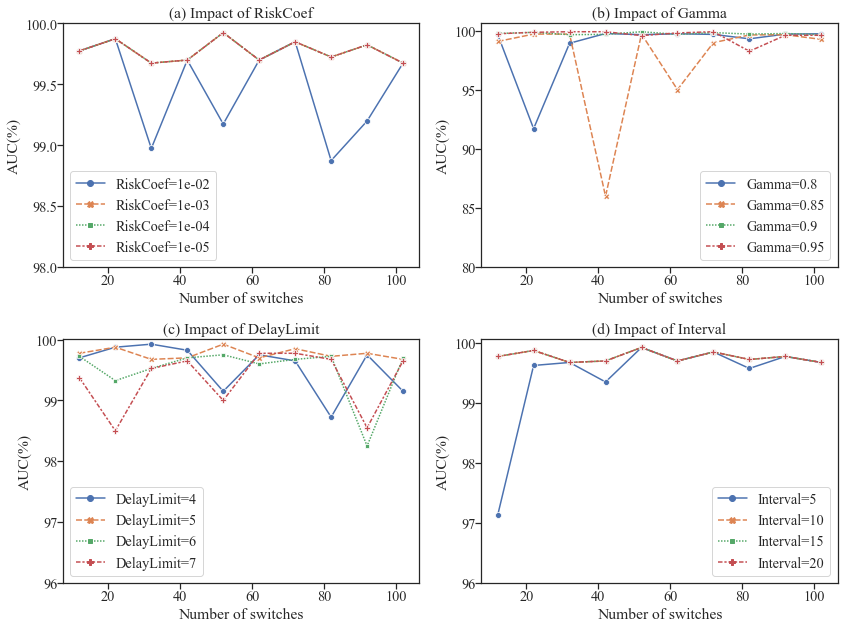

In [59]:
qs = [1e-2, 1e-3, 1e-4, 1e-5]
gammas = [0.8, 0.85, 0.9, 0.95]
delay_limits = [4, 5, 6, 7]
interval = [5, 10, 15, 20]

param_names = ['q', 'gamma','limit', 'interval']
param_objs = [qs, gammas, delay_limits, interval]
scales = [i for i in range(10, 110, 10)]
colors = ['blue', 'orange', 'green', 'red', 'maroon', 'darkviolet', 'purple']
labels = ['RiskCoef', 'Gamma', 'DelayLimit', 'Interval']

methods = ['TopoGuard+', 'TrustTopo', 'LinkGuard', 'RLV-RF',
           'RLV-MLP', 'CLV-RAW', 'CLV-OPT']
log_dirs = ['topoguard_log', 'trusttopo_log', 'linkguard_log',
            'rf_log', 'mlp_log', 'clv_log_raw', 'clv_log_opt']

f, axes = plt.subplots(2, len(param_objs)//2, figsize=(12, 9))

for i, name in enumerate(param_names):
    data = []
    for value in param_objs[i]:
        if name == 'q':
            key = '{}_{:.0e}'.format(name, value)
        else:
            key = '{}_{}'.format(name, value)
        data_by_key = []
        for scale in scales:
            log_file = 'clv_log_{}/{}/clv_log_{}.txt'.format(
                i+1, key, scale)
            auc_list = []
            with open(log_file, 'r') as fp:
                line = fp.readline()
                if not line:
                    break 
                auc_item = line.split(',')[-1]
                auc_value = auc_item.split(':')[-1]
                auc_list.append(float(auc_value)*100)
            data_by_key.append(np.round(np.mean(auc_list), 4))
        data.append(data_by_key)
    data = np.array(data)
    if name == 'q':
        columns = ['{}={:.0e}'.format(labels[i], v) for v in param_objs[i]]
    else:
        columns = ['{}={}'.format(labels[i], v) for v in param_objs[i]]
    df = pd.DataFrame(data.T, index=index, columns=columns)
    ax = sns.lineplot(data=df,ax=axes[i//2][i%2], markers=True)
    ax.set_xlabel('Number of switches')
    ax.set_ylabel('AUC(%)')
    if i == 0:
        ax.set_yticks([98, 98.5, 99, 99.5, 100])
        ax.set_title('(a) Impact of RiskCoef')
    if i == 1:
        ax.set_yticks([80, 85, 90, 95, 100])
        ax.set_title('(b) Impact of Gamma')
    elif i == 2:
        ax.set_yticks([96, 97, 98, 99, 100])
        ax.set_title('(c) Impact of DelayLimit')
    elif i == 3:
        ax.set_yticks([96, 97, 98, 99, 100])
        ax.set_title('(d) Impact of Interval')
    ax.tick_params(pad=0)

f.tight_layout()
f.savefig('parameters_2.png', format='png', bbox_inches='tight', dpi=500, transparent=True)
        

{'topoguard_log': {'TPR': [8.55], 'FPR': [9.875], 'Pr': [46.4043], 'F1': [14.4395], 'AUC': [49.3375]}, 'trusttopo_log': {'TPR': [35.75], 'FPR': [33.475], 'Pr': [51.6432], 'F1': [42.2514], 'AUC': [51.1375]}, 'linkguard_log': {'TPR': [8.6], 'FPR': [9.875], 'Pr': [46.5494], 'F1': [14.5178], 'AUC': [49.3625]}, 'rf_log': {'TPR': [57.8738], 'FPR': [47.4317], 'Pr': [55.174], 'F1': [56.4917], 'AUC': [55.221]}, 'mlp_log': {'TPR': [54.1729], 'FPR': [41.4683], 'Pr': [56.8561], 'F1': [55.4821], 'AUC': [56.3523]}, 'clv_log_raw': {'TPR': [75.35], 'FPR': [0.0], 'Pr': [100.0], 'F1': [85.9424], 'AUC': [87.675]}, 'clv_log_opt': {'TPR': [99.35], 'FPR': [0.0], 'Pr': [100.0], 'F1': [99.6739], 'AUC': [99.675]}}


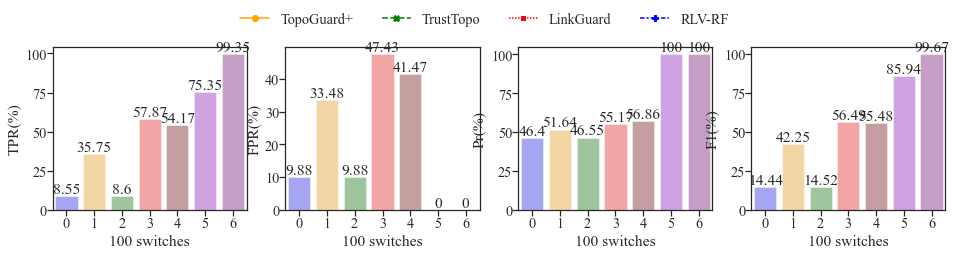

In [60]:
num_switch = 100

methods = ['TopoGuard+', 'TrustTopo', 'LinkGuard', 'RLV-RF',
           'RLV-MLP', 'CLV-RAW', 'CLV-OPT']
log_dirs = ['topoguard_log', 'trusttopo_log', 'linkguard_log',
            'rf_log', 'mlp_log', 'clv_log_raw', 'clv_log_opt']

stats = {
    '{}'.format(dir): {
        'TPR': [],
        'FPR': [],
        'Pr': [],
        'F1': [],
        'AUC': [],
    } for dir in log_dirs
}

for log_dir in log_dirs:
    log_file = '{}/{}_{}.txt'.format(log_dir, log_dir, num_switch)
    tpr_list = []
    fpr_list = []
    pr_list = []
    f1_list = []
    auc_list = []
    with open(log_file, 'r') as fp:
        line = fp.readline()
        if not line:
            break 
        tpr_item, fpr_item, pr_item, f1_item, auc_item = line.split(',')
        tpr = 100 * float(tpr_item.split(':')[1])
        fpr = 100 * float(fpr_item.split(':')[1])
        pr = 100 * float(pr_item.split(':')[1])
        f1 = 100 * float(f1_item.split(':')[1])
        auc = 100 * float(auc_item.split(':')[1])
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        pr_list.append(pr)
        f1_list.append(f1)
        auc_list.append(auc)
    med_tpr = np.mean(tpr_list)
    med_fpr = np.mean(fpr_list)
    med_pr = np.mean(pr_list)
    med_f1 = np.mean(f1_list)
    med_auc = np.mean(auc_list)
    key = '{}'.format(log_dir)
    (stats[key]['TPR']).append(np.round(med_tpr,4))
    (stats[key]['FPR']).append(np.round(med_fpr, 4))
    (stats[key]['Pr']).append(np.round(med_pr, 4))
    (stats[key]['F1']).append(np.round(med_f1, 4))
    (stats[key]['AUC']).append(np.round(med_auc, 4))

print(stats)

indicators = ['TPR', 'FPR', 'Pr', 'F1']
f, axes = plt.subplots(1, len(indicators), figsize=(16, 3))

for i, ind in enumerate(indicators):
    data = np.array([stats[dir][ind] for dir in log_dirs])
    data = np.round(data, 2)
    df = pd.DataFrame(data.T)
    ax = sns.barplot(data=df,ax=axes[i], palette=colors, alpha=0.4)
    ax.set_xlabel('100 switches')
    ax.set_ylabel('{}(%)'.format(ind))
    ax.tick_params(pad=0)
    for i, container in enumerate(ax.containers):
        ax.bar_label(container, data[i])
f.legend(lines, methods, frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(methods))
f.tight_layout()
f.savefig('100switches.png', format='png', bbox_inches='tight', dpi=300, transparent=True)


In [61]:
def stats_from_file(file):
    tpr_list = []
    fpr_list = []
    pr_list = []
    f1_list = []
    auc_list = []
    with open(file, 'r') as fp:
        while True:
            line = fp.readline()
            if not line:
                break 
            tpr_item, fpr_item, pr_item, f1_item, auc_item = line.split(',')
            tpr = 100 * float(tpr_item.split(':')[1])
            fpr = 100 * float(fpr_item.split(':')[1])
            pr = 100 * float(pr_item.split(':')[1])
            f1 = 100 * float(f1_item.split(':')[1])
            auc = 100 * float(auc_item.split(':')[1])
            tpr_list.append(tpr)
            fpr_list.append(fpr)
            pr_list.append(pr)
            f1_list.append(f1)
            auc_list.append(auc)
    return tpr_list, fpr_list, pr_list, f1_list, auc_list

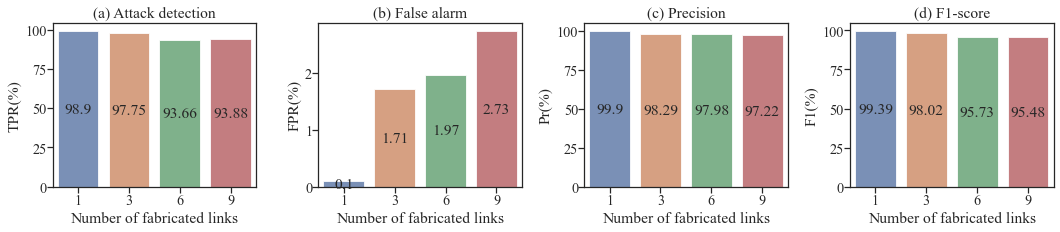

In [62]:
num_fake_links = [1, 3, 6, 9]

colors = ['orange', 'green', 'red', 'blue',]

raw_stats = {
    '{}_fake_link'.format(n): {
        'TPR': [],
        'FPR': [],
        'Pr': [],
        'F1': [],
        'AUC': [],
    } for n in num_fake_links
}

titles = ['(a) Attack detection', 
          '(b) False alarm',
          '(c) Precision',
          '(d) F1-score']

for n in num_fake_links:
    raw_file = 'clv_log_5/{}_fake_links/clv_log_raw_30.txt'.format(n)
    raw_tpr_list, raw_fpr_list, raw_pr_list, raw_f1_list, \
        raw_auc_list = stats_from_file(raw_file)
    key = '{}_fake_link'.format(n)
    (raw_stats[key]['TPR']).append(np.round(np.mean(raw_tpr_list),2))
    (raw_stats[key]['FPR']).append(np.round(np.mean(raw_fpr_list), 2))
    (raw_stats[key]['Pr']).append(np.round(np.mean(raw_pr_list), 2))
    (raw_stats[key]['F1']).append(np.round(np.mean(raw_f1_list), 2))
    (raw_stats[key]['AUC']).append(np.round(np.mean(raw_auc_list), 2))

indicators = ['TPR', 'FPR', 'Pr', 'F1']
f, axes = plt.subplots(1, len(indicators), figsize=(15, 3.5))

for i, ind in enumerate(indicators):
    raw_data = np.array([
            raw_stats['{}_fake_link'.format(n)][ind] for n in num_fake_links])
    df = pd.DataFrame(raw_data.T, columns=num_fake_links)
    ax = sns.barplot(data=df,ax=axes[i], alpha=0.8)
    ax.set_xlabel('Number of fabricated links')
    ax.set_ylabel('{}(%)'.format(ind))
    ax.set_title(titles[i])
    ax.tick_params(pad=0)
    for i, container in enumerate(ax.containers):
        ax.bar_label(container, raw_data[i], label_type='center')
f.tight_layout()
f.savefig('fakelinks_raw.png', format='png', bbox_inches='tight', dpi=300)

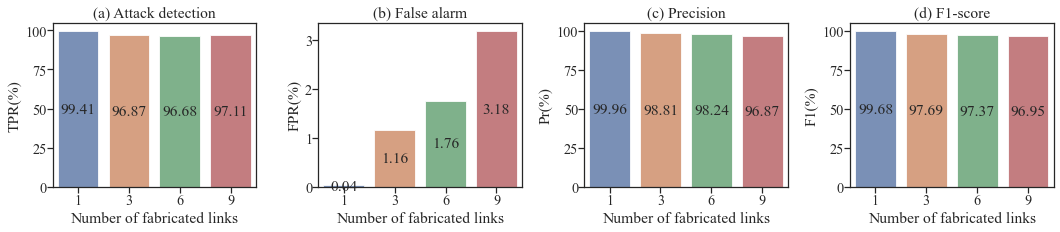

In [63]:
num_fake_links = [1, 3, 6, 9]

colors = ['orange', 'green', 'red', 'blue',]

opt_stats = {
    '{}_fake_link'.format(n): {
        'TPR': [],
        'FPR': [],
        'Pr': [],
        'F1': [],
        'AUC': [],
    } for n in num_fake_links
}

titles = ['(a) Attack detection', 
          '(b) False alarm',
          '(c) Precision',
          '(d) F1-score']

for n in num_fake_links:
    opt_file = 'clv_log_5/{}_fake_links/clv_log_opt_30.txt'.format(n)
    opt_tpr_list, opt_fpr_list, opt_pr_list, opt_f1_list, \
        opt_auc_list = stats_from_file(opt_file)
    key = '{}_fake_link'.format(n)
    (opt_stats[key]['TPR']).append(np.round(np.mean(opt_tpr_list),2))
    (opt_stats[key]['FPR']).append(np.round(np.mean(opt_fpr_list), 2))
    (opt_stats[key]['Pr']).append(np.round(np.mean(opt_pr_list), 2))
    (opt_stats[key]['F1']).append(np.round(np.mean(opt_f1_list), 2))
    (opt_stats[key]['AUC']).append(np.round(np.mean(opt_auc_list), 2))
    

indicators = ['TPR', 'FPR', 'Pr', 'F1']
f, axes = plt.subplots(1, len(indicators), figsize=(15, 3.5))

for i, ind in enumerate(indicators):
    opt_data = np.array([
            opt_stats['{}_fake_link'.format(n)][ind] for n in num_fake_links])

    df = pd.DataFrame(opt_data.T, columns=num_fake_links)
    ax = sns.barplot(data=df,ax=axes[i], alpha=0.8)
    ax.set_xlabel('Number of fabricated links')
    ax.set_ylabel('{}(%)'.format(ind))
    ax.set_title(titles[i])
    ax.tick_params(pad=0)
    for i, container in enumerate(ax.containers):
        ax.bar_label(container, opt_data[i], label_type='center')
f.tight_layout()
f.savefig('fakelinks_opt.png', format='png', bbox_inches='tight', dpi=300)

{'delay_0.1ms': {'TPR': [7.77], 'FPR': [0.0], 'Pr': [100.0], 'F1': [14.09], 'AUC': [53.89]}, 'delay_0.3ms': {'TPR': [28.57], 'FPR': [0.62], 'Pr': [98.6], 'F1': [42.84], 'AUC': [63.98]}, 'delay_0.5ms': {'TPR': [96.91], 'FPR': [0.05], 'Pr': [99.95], 'F1': [98.39], 'AUC': [98.43]}, 'delay_0.7ms': {'TPR': [96.99], 'FPR': [0.19], 'Pr': [99.82], 'F1': [98.36], 'AUC': [98.4]}}
[7.77]
[0.]
[100.]
[14.09]


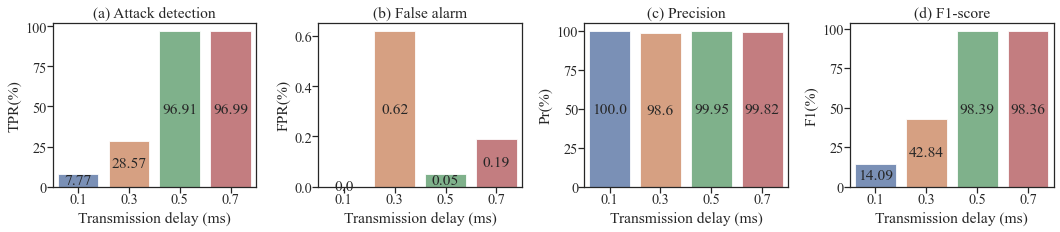

In [64]:
delays = [0.1, 0.3, 0.5, 0.7]

colors = ['orange', 'green', 'red', 'blue',]

raw_stats = {
    'delay_{}ms'.format(d): {
        'TPR': [],
        'FPR': [],
        'Pr': [],
        'F1': [],
        'AUC': [],
    } for d in delays
}

titles = ['(a) Attack detection', 
          '(b) False alarm',
          '(c) Precision',
          '(d) F1-score']

# TPR:0.9955,FPR:0.0,Pr:1.0,F1:0.9977449260836884,AUC:0.99775
for d in delays:
    opt_file = 'clv_log_6/delay_{}ms/clv_log_raw_30.txt'.format(d)
    opt_tpr_list, opt_fpr_list, opt_pr_list, opt_f1_list, \
        opt_auc_list = stats_from_file(opt_file)
    key = 'delay_{}ms'.format(d)
    (raw_stats[key]['TPR']).append(np.round(np.mean(opt_tpr_list),2))
    (raw_stats[key]['FPR']).append(np.round(np.mean(opt_fpr_list), 2))
    (raw_stats[key]['Pr']).append(np.round(np.mean(opt_pr_list), 2))
    (raw_stats[key]['F1']).append(np.round(np.mean(opt_f1_list), 2))
    (raw_stats[key]['AUC']).append(np.round(np.mean(opt_auc_list), 2))

print(raw_stats)
indicators = ['TPR', 'FPR', 'Pr', 'F1']
f, axes = plt.subplots(1, len(indicators), figsize=(15, 3.5))

for i, ind in enumerate(indicators):
    data = np.array([
            raw_stats['delay_{}ms'.format(d)][ind] for d in delays])
    df = pd.DataFrame(data.T, columns=delays)
    ax = sns.barplot(data=df,ax=axes[i], alpha=0.8)
    ax.set_xlabel('Transmission delay (ms)')
    ax.set_ylabel('{}(%)'.format(ind))
    # if ind == 'FPR':
    #     ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
    ax.tick_params(pad=0)
    ax.set_title(titles[i])
    for i, container in enumerate(ax.containers):
        print(data[i])
        ax.bar_label(container, data[i], label_type='center')
f.tight_layout()
f.savefig('delays_raw.png', format='png', bbox_inches='tight', dpi=300)

{'delay_0.1ms': {'TPR': [94.5], 'FPR': [0.18], 'Pr': [99.81], 'F1': [97.05], 'AUC': [97.16]}, 'delay_0.3ms': {'TPR': [95.95], 'FPR': [0.04], 'Pr': [99.96], 'F1': [97.9], 'AUC': [97.95]}, 'delay_0.5ms': {'TPR': [99.53], 'FPR': [0.03], 'Pr': [99.97], 'F1': [99.75], 'AUC': [99.75]}, 'delay_0.7ms': {'TPR': [99.52], 'FPR': [0.0], 'Pr': [100.0], 'F1': [99.76], 'AUC': [99.76]}}
[94.5]
[0.18]
[99.81]
[97.05]


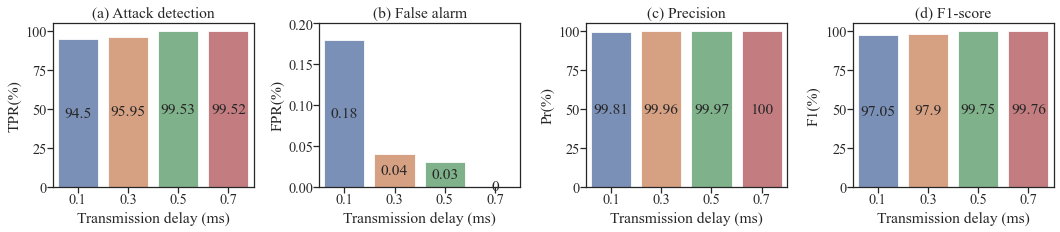

In [65]:
delays = [0.1, 0.3, 0.5, 0.7]

colors = ['orange', 'green', 'red', 'blue',]

opt_stats = {
    'delay_{}ms'.format(d): {
        'TPR': [],
        'FPR': [],
        'Pr': [],
        'F1': [],
        'AUC': [],
    } for d in delays
}
titles = ['(a) Attack detection', 
          '(b) False alarm',
          '(c) Precision',
          '(d) F1-score']

# TPR:0.9955,FPR:0.0,Pr:1.0,F1:0.9977449260836884,AUC:0.99775
for d in delays:
    opt_file = 'clv_log_6/delay_{}ms/clv_log_opt_30.txt'.format(d)
    opt_tpr_list, opt_fpr_list, opt_pr_list, opt_f1_list, \
        opt_auc_list = stats_from_file(opt_file)
    key = 'delay_{}ms'.format(d)
    (opt_stats[key]['TPR']).append(np.round(np.mean(opt_tpr_list),2))
    (opt_stats[key]['FPR']).append(np.round(np.mean(opt_fpr_list), 2))
    (opt_stats[key]['Pr']).append(np.round(np.mean(opt_pr_list), 2))
    (opt_stats[key]['F1']).append(np.round(np.mean(opt_f1_list), 2))
    (opt_stats[key]['AUC']).append(np.round(np.mean(opt_auc_list), 2))

print(opt_stats)
indicators = ['TPR', 'FPR', 'Pr', 'F1']
f, axes = plt.subplots(1, len(indicators), figsize=(15, 3.5))

for i, ind in enumerate(indicators):
    data = np.array([
            opt_stats['delay_{}ms'.format(d)][ind] for d in delays])
    df = pd.DataFrame(data.T, columns=delays)
    ax = sns.barplot(data=df,ax=axes[i], alpha=0.8)
    ax.set_xlabel('Transmission delay (ms)')
    ax.set_ylabel('{}(%)'.format(ind))
    if ind == 'FPR':
        ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
    ax.tick_params(pad=0)
    ax.set_title(titles[i])
    for i, container in enumerate(ax.containers):
        print(data[i])
        ax.bar_label(container, data[i], label_type='center')
f.tight_layout()
f.savefig('delays_opt.png', format='png', bbox_inches='tight', dpi=300)